# Breast Cancer Treatment Prediction Project
this is part of the NRT-ICGE project in collaboration with Dr. Ben Brown and Dr. Petrus Zwart of Lawrence Berkeley National Lab

## Purpose of the Notebook : Varifying Our Results

In the notebook below, we aim to track the error for both the testing data and the training data and lastly making a plot of these vs the epochs.
The code below is taken from the original network architechure, but with additions to save the error values.


## Import all the needed libraries and packages : 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 23 14:58:06 2019

@author: aliheydari
"""
from __future__ import print_function, division
import os
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils import data
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
     warnings.filterwarnings("ignore",category=DeprecationWarning)

Check the for the available device (preferably GPUs).
As of now, multiple GPU utilization is not available. Ali hopes to have that done sometime soon (but who knows). The code may need to be written in TF.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if str(device) == "cuda":
	print("Using GPU")
else:
	print("Using CPU")

Using GPU


## Network 
In this section we define the architecture of our network. This architecture is exactly the same as the original network, which is too simple to do what we want to do; but it works for some reason (probably a mistake but we'll see).

In [3]:
#
## Simple feed forward NN ##
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        # inherited from the parent class nn.Module
        super(Net, self).__init__()            
        # first layer of the full-connected Layer: 19163 [Inp] -> 100 
        # OR 19163 [inp] -> [however many hidden neurons you have]
        self.fc1 = nn.Linear(input_size, hidden_size) 
#        self.normal(self.fc1.weight, mean=0, std=1)
        # for the fuck of it, let's pick ReLU
        self.relu = nn.ReLU()                     
        # and if we need softmax
        self.softmax = nn.Softmax()
        
        # second full-connected layer: 100  [Hid Node] -> 2 [Binary Outp]
        self.fc2 = nn.Linear(hidden_size, num_classes) 
        
        ## HERE ^^ WE HAVE ROOM TO ADD MORE LAYERS IF WE WANT TO ##
    
    def forward(self, x):     
#        print(x.shape)
#        print("oh SHIT")
#        x = x.view(x.size(0), -1)     
                  
        # forward pass: stacking each layer together
        out = self.relu(x);
        out = self.fc1(out)
#        out = self.relu(out)
        out = self.softmax(out)
        out = self.fc2(out)
        
        
        
        ## here we would need more "out"s if we add more layers  in ^^ ##
        
        
        return out

## Data Formatting

Here we will read the data that *Deepika* has manipulated to numpy arrays to later be used as tensors for our network. 

### Law of Conservation of Data: 
No data is being created or destroyed below, but simply put into different compartments.

In [4]:
# read the data
train_data = open("train_matrix.tsv", "r+");
#test_data = open("test_matrix.tsv", "r+");

test_data = open("test_matrix.tsv", "r+");

resp_data = open("train_response.tsv", "r+");
#test_resp_data = open("test_response.tsv", "r+");
test_resp_data = open("test_response.tsv", "r+");


# init the NUMPY arrays (later need tensors)
train = [];
tr_resp = [];
test = [];
tst_resp = [];
labels = [];

# use fucking pandas to read the data and get rid of tabs
tr_df = pd.read_csv(train_data, sep="\t");   #  .tsv file into memory
ts_df = pd.read_csv(test_data, sep="\t");
tr_rs_df = pd.read_csv(resp_data, sep="\t",na_values=' ');

"""
NOTE: if you wanna use the code below, make sure to add the column headers to
the treatment response tsv file : )
    
"""
## we only need second column because second column has the 0 and 1 ##
tr_rs_df = tr_rs_df["COL2"];
ts_rs_df = pd.read_csv(test_resp_data, sep="\t");
ts_rs_df = ts_rs_df["COL2"];


# get only the numerical values of the arrays
train = tr_df.values;
test = ts_df.values;
train_resp = tr_rs_df.values;
test_resp = ts_rs_df.values;

### Parameters
Here we import the file <code> params.py </code> in order to read the dictionary and use the given values

In [5]:
import params

args = params.set_hyper();

# print the hyperparameters 
params.print_hyp(args);


Input size : 19163 
Hidden size : 100 
number of classes (outputs) : 2 
Learning Rate (step sizes for GD) : 0.05 
number of epochs : 1500


## Data Tensors + Network Initialization

First we convert the numpy arrays (data + labels) to tensors and then we load them to PT data loaders. After that, we initlize the network and are ready to train

In [6]:
# turn NUMPY arrays to TENSORS
test_dataset = torch.from_numpy(test);
train_dataset = torch.from_numpy(train);
test_dataset.type(torch.FloatTensor);
train_dataset.type(torch.FloatTensor);

## these are the answers to responses that the patients had ##

# training labels
labels = train_resp; 
# testing labels
labels2 = test_resp; 
# turn to tensors
labels = torch.from_numpy(labels);
labels2 = torch.from_numpy(labels2);
# an absolutely useless step (redonded) but as a safty in case we forget WTF
resp_dataset = torch.from_numpy(train_resp);
test_resp_dataset = torch.from_numpy(test_resp);


# use pytorch's amazing data utilities
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=True);

## on purpose
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=False);
# init NN
net = Net(args.input_size, args.hidden_size, args.num_classes).to(device);

# loss function
#criterion = nn.NLLLoss()
## cross entropy combines this ^^ and logSoftmax AND it works better
criterion = nn.CrossEntropyLoss().to(device);
#criterion = nn.BCELoss();

optimizer = torch.optim.SGD(net.parameters(), lr=args.learning_rate)

## Output Files

These are the txt files we will be outputting and using for the plts

In [7]:
### TRAIN and Evaluate Training set ###
training_error = [];
test_error = [];
epoch_arr = [];
loss_arr = [];
valid_error = [];



# the files we are gonna be writin to

TrErr_file = open("training_error.txt","w+");
TesErr_file = open("test_error.txt","w+");
Epoch_num_file = open("num_epochs.txt","w+");
loss_file = open("loss.txt","w+");


## Train

Below is the step for training and testing the network

In [8]:

counter = 0;
for epoch in range(args.num_epochs):
    
    # load a batch of our data
    for i,dat in enumerate(train_loader):  
        counter += 1;
        
        # convert TENSORS to VARIABLES for symbolic calculations
        dat = Variable(train_dataset.float()).to(device);
        labels = Variable(labels).to(device);

        # init the hidden weights all zeros!
        optimizer.zero_grad()      
        # here we go: FORWARD pass                      
        outputs = net(dat)                                
        # compute the loss based on the criteria: our case cross entropy!!!
        loss = criterion(outputs, labels)          
        # here we go2: BACKWARD pass (and compute the weights!)
        loss.backward()                                   
        # optimizer: update the weights of hidden nodes
        optimizer.step()                                  
#         trained_weights1 = net.fc1.weight.data;
#         trained_weights2 = net.fc2.weight.data;
        counter += 1;
#         w = list(net.fc1.parameters());
#        torch.save(net.state_dict(), "NN_model_{0:03d}.txt".format(epoch)) 
        
#         this is a step purely for printing out the steps
        if counter % 10 == 0:                              
#             need to fix my math here... HELP!!!
#            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                 %(epoch+1, num_epochs, i + 1, len(train_dataset)//batch_size, loss.data))
            temp = loss.data;
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, args.num_epochs, i + 1, len(train_dataset)//args.batch_size, loss.data))
            loss_file.write('%.4f'%(loss.data));
            loss_file.write("\n");
            Epoch_num_file.write('%d'%(epoch+1));
            Epoch_num_file.write("\n");
    
    ### TEST ###


#### Just to make sure that the network is trained on the training data ####

    correct = 0
    total = len(train)

    counter = 0
    for dat in train_loader: 
       counter += 1;
       dat = Variable(train_dataset.float()).to(device)
       outputs = net(dat)

    # #    choose the best class from the output --> The class with the best score
       _, predicted1 = torch.max(outputs.data, 1)
    #    # += the total count
    #    total += labels.size(0) 
    # #    # += the total corrects!            

    for q in range (0,len(labels)):
        if predicted1[q] == labels[q]:
            correct +=1;
        
    training_error.append([100 * correct / total]);
    print(training_error[-1]);
    TrErr_file.write("%s\n"%(training_error[-1]));
#     TrErr_file.write("\n");
    
    #    correct += (predicted1 == labels).sum()     # Increment the correct count

#     print('Accuracy of the network on the training data: %d %%' % (100 * correct / total))
#     print("THIS ^^^ SHOULD BE 100%")

    correct = 0
    total = len(test)

    counter = 0
    for dat in test_loader: 
       counter += 1;
       dat = Variable(train_dataset.float()).to(device)
       outputs = net(dat)

    # #    choose the best class from the output --> The class with the best score
       _, predicted1 = torch.max(outputs.data, 1)
    #    # += the total count
    #    total += labels.size(0) 
    # #    # += the total corrects!            
    
    ##### MAKE SURE TO CHANGE THIS TO labels2 ######
    for z in range (0,len(labels)):
        if predicted1[z] == labels[z]:
            correct +=1;
    #    correct += (predicted1 == labels).sum()     # Increment the correct count
    test_error.append([100 * correct / total]);
    TesErr_file.write("%s\n"%(test_error[-1]));
#     TesErr_file.write("\n");
    
    print(test_error[-1]);
    
    
    
    
    
    
    
    

[59.006211180124225]
[56.37982195845697]
Epoch [2/1500], Step [3/3], Loss: 0.6872
[59.006211180124225]
[56.37982195845697]
Epoch [3/1500], Step [3/3], Loss: 0.6853
[59.006211180124225]
[56.37982195845697]
Epoch [4/1500], Step [3/3], Loss: 0.6837
[59.006211180124225]
[56.37982195845697]
Epoch [5/1500], Step [3/3], Loss: 0.6825
[59.006211180124225]
[56.37982195845697]
Epoch [6/1500], Step [3/3], Loss: 0.6814
[59.006211180124225]
[56.37982195845697]
Epoch [7/1500], Step [3/3], Loss: 0.6806
[59.006211180124225]
[56.37982195845697]
Epoch [8/1500], Step [3/3], Loss: 0.6799
[59.006211180124225]
[56.37982195845697]
Epoch [9/1500], Step [3/3], Loss: 0.6793
[59.006211180124225]
[56.37982195845697]
Epoch [10/1500], Step [3/3], Loss: 0.6789
[59.006211180124225]
[56.37982195845697]
Epoch [11/1500], Step [3/3], Loss: 0.6785
[59.006211180124225]
[56.37982195845697]
Epoch [12/1500], Step [3/3], Loss: 0.6782
[59.006211180124225]
[56.37982195845697]
Epoch [13/1500], Step [3/3], Loss: 0.6779
[59.00621118

## Plot the Results 

Below we will plot the accuracies of the train/test accuracies vs. epoch

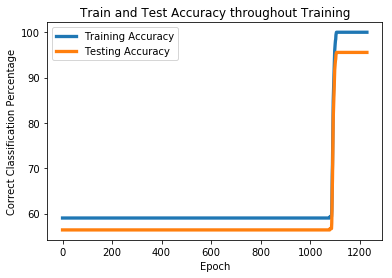

In [21]:
train_str = open("training_error.txt","r+")
test_str = open("test_error.txt","r+")

bad_chars = ['[',']'];
# this way is not efficient at all, but for now it's good
test_acc = np.zeros(0)
train_acc = np.zeros(0);

# write the strings to a numpy array 
# training accuracy
for line in train_str:
    for i in bad_chars:
        line = line.replace(i, '')
    
    flt = float(line);    
    train_acc = np.hstack((train_acc,flt))

# testing accuracy 
for line in test_str:
    for i in bad_chars:
        line = line.replace(i, '')
    
    flt = float(line);    
    test_acc = np.hstack((test_acc,flt))    
    
x = np.arange(len(test_acc))


plt.plot(x,train_acc[0:1230],x,test_acc,linewidth=3.3)

plt.legend(('Training Accuracy', 'Testing Accuracy'))
plt.xlabel('Epoch')
plt.ylabel('Correct Classification Percentage')

# with AdaLearn
# plt.title('Adaptive and Non Adaptive with AdaLearn for Both')
## Without AdaLearn

plt.title('Train and Test Accuracy throughout Training')
plt.savefig('train_&_test_acc.png',dpi = 1080)


## More Testing On the Way 

this is just one very simple way of checking how the network is reaching these accuracies. We have done more testing and will find out better ways of testing our network and how we can be more sure of our results.